# Adversarial Attack on MNIST

Here, we use the tutorial "Deep MNIST for experts" inspired by this link- https://github.com/DobrinGanev/Deep-MNIST-for-Experts-Tensorflow-Example/blob/master/multilayer-convolutional-network.ipynb

The functions are modified to use tf.keras API.

# Import packages

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm

# Load MNIST dataset

In [86]:
#Read the input data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Check a sample image

Training image shape (55000, 784)
Training labels shape (55000, 10)
Shape of an image (1, 784)


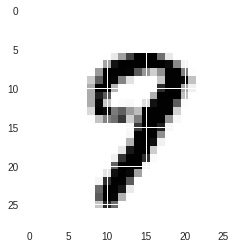

In [87]:
#Explore the data
sample_image = mnist.train.next_batch(1)[0]
print("Training image shape", mnist.train.images.shape)
print("Training labels shape", mnist.train.labels.shape)
print("Shape of an image", sample_image.shape)
sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image)

# Create placeholder for Image and Labels

In [0]:
x = tf.keras.backend.placeholder(shape=[None, 784], dtype=tf.float32)
y_ = tf.keras.backend.placeholder(shape=[None, 10], dtype=tf.float32)

# Create function for Convolution and MaxPooling based on the tutorial for "Deep MNIST for experts". Here conv2d and maxpooling use tf.keras API.

In [0]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Functions for convolution and pooling functions
def conv2d(x, W):
    return tf.keras.backend.conv2d(x, W, strides=(1, 1), padding='same')

def max_pooling_2x2(x):
    return tf.keras.backend.pool2d(x, pool_size=(2,2), strides=(2,2), padding='same')

# Create Convolutional Neural Network

In [0]:
x_image = tf.reshape(x, [-1,28,28,1])

# Conv layer 1 - 32x5x5
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
x_pool1 = max_pooling_2x2(x_conv1)

# Conv layer 2 - 64x5x5
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
x_conv2 = tf.nn.relu(conv2d(x_pool1, W_conv2) + b_conv2)
x_pool2 = max_pooling_2x2(x_conv2)

# Flatten
x_flat = tf.reshape(x_pool2, [-1, 7*7*64])

# Dense fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
x_fc1 = tf.nn.relu(tf.matmul(x_flat, W_fc1) + b_fc1)

# Regularization with dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2

# Probabilities, Loss, Optimizer and Test Accuracy initialization

In [0]:
# Get Probabilities
y = tf.nn.softmax(y_conv)

In [0]:
# Loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [0]:
# Test accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize global variables for training

In [102]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Start training

In [103]:
for i in tqdm(range(1000)):
    batch = mnist.train.next_batch(100)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})

  0%|          | 0/1000 [00:00<?, ?it/s]

step 0, training accuracy 0.08


 20%|██        | 200/1000 [01:05<04:36,  2.89it/s]

step 200, training accuracy 0.92


 40%|████      | 400/1000 [02:12<03:17,  3.04it/s]

step 400, training accuracy 0.97


 60%|██████    | 600/1000 [03:18<02:11,  3.04it/s]

step 600, training accuracy 0.9


 80%|████████  | 800/1000 [04:25<01:06,  3.02it/s]

step 800, training accuracy 0.95


100%|██████████| 1000/1000 [05:31<00:00,  3.01it/s]


# Print Accuracy on test data

In [104]:
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images[0:500], 
                                                  y_: mnist.test.labels[0:500], keep_prob: 1.0}))

test accuracy 0.974


# Filter Index for 2s images and the images

In [0]:
index_of_2s = np.nonzero(mnist.test.labels[0:500][:,2])[0][0:10]
x_batch = mnist.test.images[index_of_2s]

# Print probabilities and predictions for chosen images

In [106]:
prediction = tf.argmax(y,1)
prediction_val = prediction.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)
print("predictions", prediction_val)
probabilities = y
probabilities_val = probabilities.eval(feed_dict={x: x_batch, keep_prob: 1.0}, session=sess)
print ("probabilities", probabilities_val)

predictions [2 2 2 2 2 2 2 2 2 2]
probabilities [[1.56508468e-03 1.47637082e-04 9.97624934e-01 3.37477162e-04
  1.99293231e-06 2.13476997e-05 2.31818281e-04 2.05323872e-07
  6.92450922e-05 2.96855291e-07]
 [4.23520441e-06 1.18970147e-05 9.99607980e-01 2.94290134e-04
  1.18894043e-07 3.24088760e-05 1.59794627e-06 1.60670220e-06
  4.34652939e-05 2.44974376e-06]
 [1.19456742e-02 2.23658346e-02 8.03730845e-01 1.45048842e-01
  4.74397020e-05 1.19062082e-03 2.31672986e-03 4.88327933e-04
  1.27689913e-02 9.66554217e-05]
 [1.64975754e-05 7.32558430e-04 9.98868108e-01 1.83574579e-04
  7.27061415e-05 3.77312863e-05 4.44268298e-05 1.69812483e-05
  2.50441772e-05 2.52084033e-06]
 [2.81655866e-06 2.00796385e-05 9.99813259e-01 6.25639659e-05
  3.79861049e-05 2.18809123e-06 4.93554799e-05 2.44167177e-06
  8.70759868e-06 6.89782553e-07]
 [1.20226876e-03 3.54212739e-06 9.71972287e-01 2.67302319e-02
  6.53286907e-06 1.48060499e-05 3.79332278e-06 2.15168857e-05
  4.44925317e-05 4.32702166e-07]
 [2.120846

# Plot images with probabilities

Correct label 0
Predicted label: 2
Confidence: 0.99762493


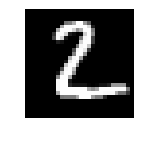

Correct label 0
Predicted label: 2
Confidence: 0.999608


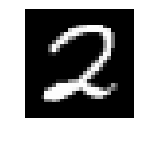

Correct label 0
Predicted label: 2
Confidence: 0.80373085


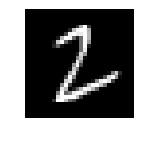

Correct label 0
Predicted label: 2
Confidence: 0.9988681


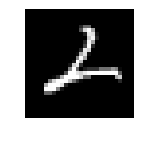

Correct label 0
Predicted label: 2
Confidence: 0.99981326


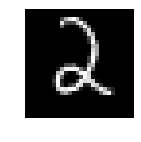

Correct label 0
Predicted label: 2
Confidence: 0.9719723


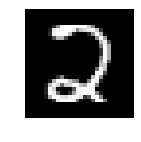

Correct label 0
Predicted label: 2
Confidence: 0.9824746


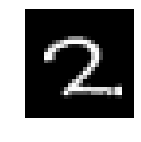

Correct label 0
Predicted label: 2
Confidence: 0.99999964


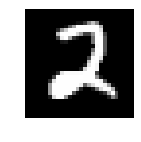

Correct label 0
Predicted label: 2
Confidence: 0.99787724


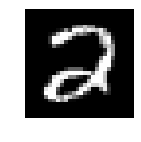

Correct label 0
Predicted label: 2
Confidence: 0.7571949


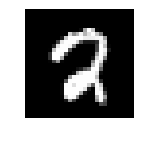

In [107]:
for i in range(0, 10):
    print('Correct label', np.argmax(index_of_2s[i]))
    print('Predicted label:', prediction_val[i])
    print('Confidence:', np.max(probabilities_val[i]))
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(x_batch[i].reshape([28, 28]),cmap = "gray")
    plt.show()

# Initialize target label and the matrix for the adversarial attack

In [0]:
target_number = 6
target_labels = np.zeros(original_labels.shape)
target_labels[:, target_number] = 1

# Initialize gradient for Adversarial attack

In [0]:
img_gradient = tf.gradients(cross_entropy, x)[0]

# Initialize value for step size and number of steps

In [0]:
step_size = 0.2
steps = 10

# Calculate Image Gradient and run FGSM attack

In [112]:
adversarial_img = x_batch.copy()
adv_img_hist = list()
prob2_hist = list()
prob6_hist = list()
for i in range(0, steps):
    gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
    adversarial_img = adversarial_img - step_size * np.sign(gradient)
    adv_img_hist.append(adversarial_img)
    prediction = tf.argmax(y,1)
    prediction_val = prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    print("predictions", prediction_val)
    probabilities = y
    probabilities_val = probabilities.eval(feed_dict = {x: adversarial_img, keep_prob: 1.0}, session=sess)
    print('Confidence 2:', probabilities_val[:, 2])
    print('Confidence 6:', probabilities_val[:, 6])
prob2_hist.append(probabilities_val[:,2])
prob6_hist.append(probabilities_val[:,6])

predictions [6 6 6 6 6 6 6 2 6 6]
Confidence 2: [1.9258109e-03 1.6377331e-01 4.6534344e-04 1.2659092e-01 1.8603748e-02
 2.5788921e-01 1.4586066e-01 9.8397142e-01 3.6398984e-02 5.1184859e-02]
Confidence 6: [0.9804155  0.6088897  0.91921973 0.7576219  0.9025525  0.5702057
 0.47788936 0.01203547 0.6397945  0.35135284]
predictions [6 6 6 6 6 6 6 6 6 6]
Confidence 2: [8.4294965e-07 1.9711870e-06 1.9013413e-07 3.2630858e-06 8.5135844e-07
 2.0201853e-06 7.0475057e-06 1.7746222e-04 5.9080503e-05 9.3822957e-05]
Confidence 6: [0.9999981  0.99999    0.99994206 0.99991894 0.9999896  0.99994993
 0.99992275 0.9974172  0.99992263 0.9997352 ]
predictions [6 6 6 6 6 6 6 6 6 6]
Confidence 2: [9.8236575e-12 2.4442037e-10 4.8701994e-09 2.5684421e-09 7.6039850e-09
 5.2884475e-09 7.6069444e-09 1.4216489e-06 1.4868227e-10 2.4197273e-09]
Confidence 6: [1.         1.         1.         1.         1.         1.
 1.         0.99999857 1.         1.        ]
predictions [6 6 6 6 6 6 6 6 6 6]
Confidence 2: [4.7224

# Plot Image grid of original image, adversarial image and noise

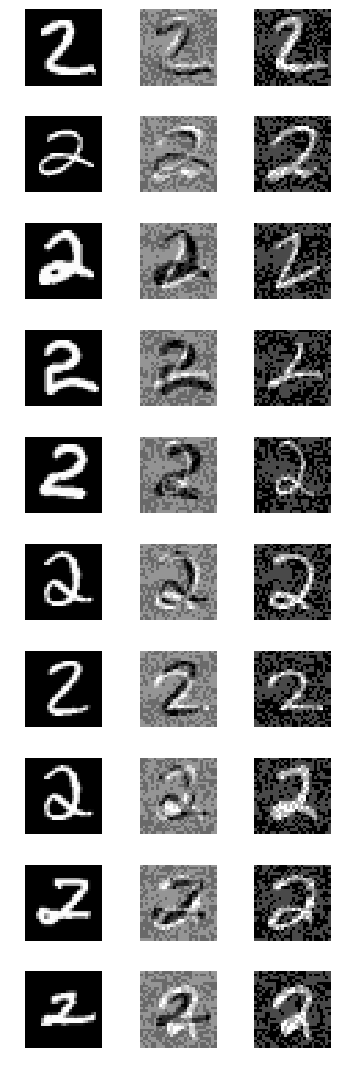

In [113]:
f, axarr = plt.subplots(10, 3, figsize=(5,15))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 250
for i in range(10):
    axarr[i,0].set_axis_off()
    axarr[i,1].set_axis_off()
    axarr[i,2].set_axis_off()
    axarr[i,0].imshow(original_images[i].reshape([28, 28]), cmap = "gray")
    axarr[i,1].imshow((adv_img_hist[0][i] - original_images[i]).reshape([28, 28]), cmap = "gray")
    axarr[i,2].imshow((adv_img_hist[0][i]).reshape([28, 28]), cmap="gray")
    
plt.tight_layout()
plt.show()